# IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import random_graph, pdmm, pdmm_median

reload(random_graph)
reload(pdmm)
reload(pdmm_median)

from random_graph import *
from pdmm import *
from pdmm_median import *
from rho_pdmm import *
from gossip import *
from drop import *

### Generate Graph

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Graph parameters
a = 100                             # Field size
n = 103                             # Number of agents
r = a * np.sqrt(2 * np.log(n)/n)   # Communication range
r = 30
#159 20 too many edges
# Generate agent positions
field_range = np.array([[0, a], [0, a]])
sensor_positions = np.array([
    np.random.uniform(field_range[0, 0], field_range[0, 1], n),
    np.random.uniform(field_range[1, 0], field_range[1, 1], n)
])

# THIS IS NOT THE ADJACENCY MATRIX, IN THIS PROBLEM IT IS EQUIVALENT TO THE INCIDENCE MATRIX
# Calculate adjacency matrix based on communication range
adjacency_matrix = calculate_adjacency_matrix(sensor_positions, r)
sensor_values = np.random.randn(n) * 10 + 25

Plot graph and check connectivity

The communication range is: 30.00
The graph is connected: True


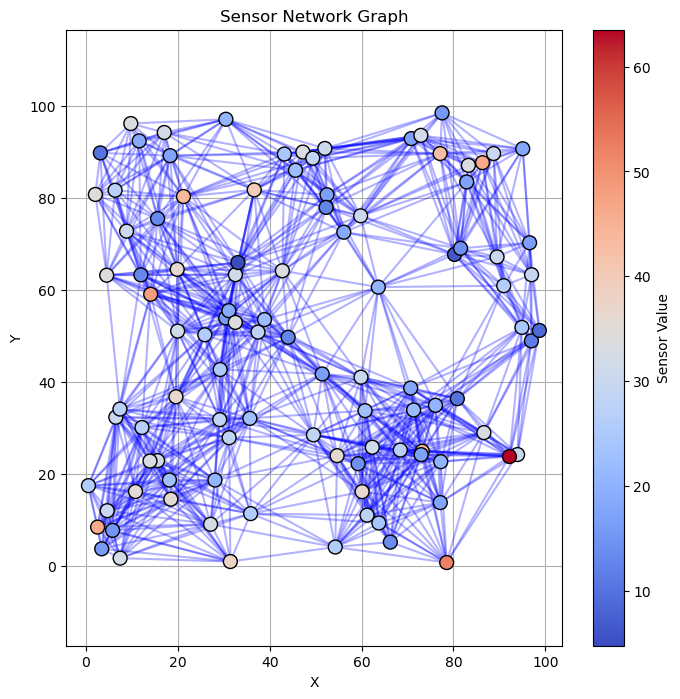

In [3]:
print(f"The communication range is: {r:.2f}")
print(f"The graph is connected: {is_connected(adjacency_matrix)}") # Is connected is not working
plot_graph(sensor_positions, adjacency_matrix, sensor_values)

### Randomized Gossip


Error below tolerance (9.979910734271961e-13) reached at transmission number 33060.


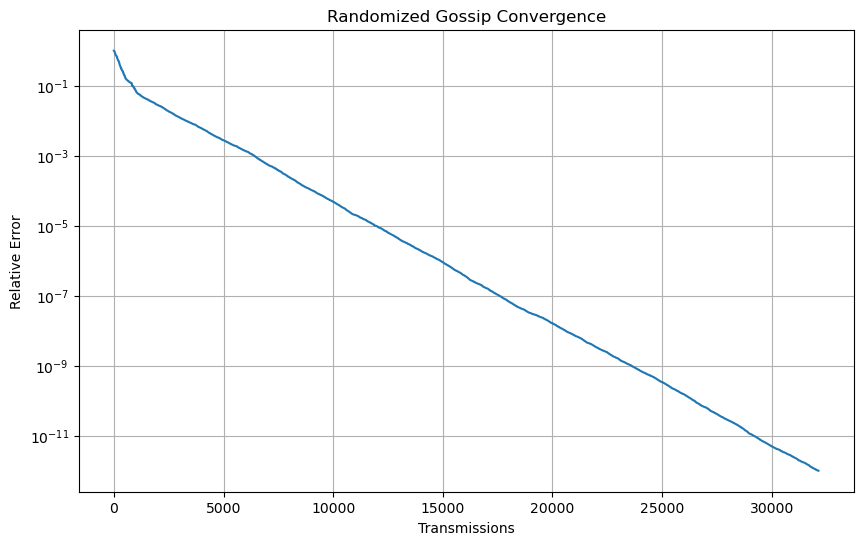

True average: 24.9152
Final average across agents: 24.9152
Min agent value: 24.9152, Max agent value: 24.9152
Final relative error: 9.9799e-13


In [4]:
sensor_values = np.random.randn(n) * 10 + 25
values,errors,time = gossip_step(sensor_values, adjacency_matrix, max_ticks=1e5, tolerance=1e-12, transmission_loss=0.00)


plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Randomized Gossip Convergence')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

### Run Synchronous PDMM

(SYNC PDMM) Error below tolerance (9.968556612307699e-13) reached.


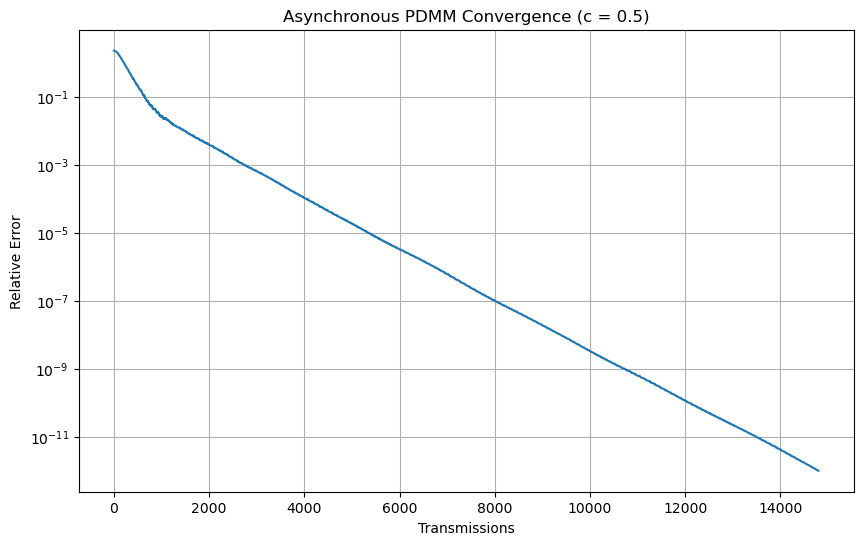

True average: 25.7757
Final average across agents: 25.7757
Min agent value: 25.7757, Max agent value: 25.7757
Final relative error: 9.9686e-13


In [45]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25

errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Asynchronous PDMM Convergence (c = {rho})')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

Compare the effect of C values - this runs too long

(SYNC PDMM) Error below tolerance (9.993177259200685e-13) reached.
(SYNC PDMM) Error below tolerance (9.87959162738938e-13) reached.
(SYNC PDMM) Error below tolerance (9.806515733914311e-13) reached.
(SYNC PDMM) Error below tolerance (9.973132897896878e-13) reached.
(SYNC PDMM) Error below tolerance (9.97133629146029e-13) reached.
(SYNC PDMM) Error below tolerance (9.994890729420428e-13) reached.
(SYNC PDMM) Error below tolerance (9.9872875925798e-13) reached.
(SYNC PDMM) Error below tolerance (9.989307786705398e-13) reached.
(SYNC PDMM) Error below tolerance (9.99345566118339e-13) reached.
(SYNC PDMM) Error below tolerance (9.959877086955409e-13) reached.
(ASYNC PDMM) Error below tolerance (9.999824045284652e-13) reached.
(ASYNC PDMM) Error below tolerance (9.990265435513731e-13) reached.
(ASYNC PDMM) Error below tolerance (9.6983998163996e-13) reached.
(ASYNC PDMM) Error below tolerance (9.997599598241327e-13) reached.
(ASYNC PDMM) Error below tolerance (9.988397179731753e-13) reache

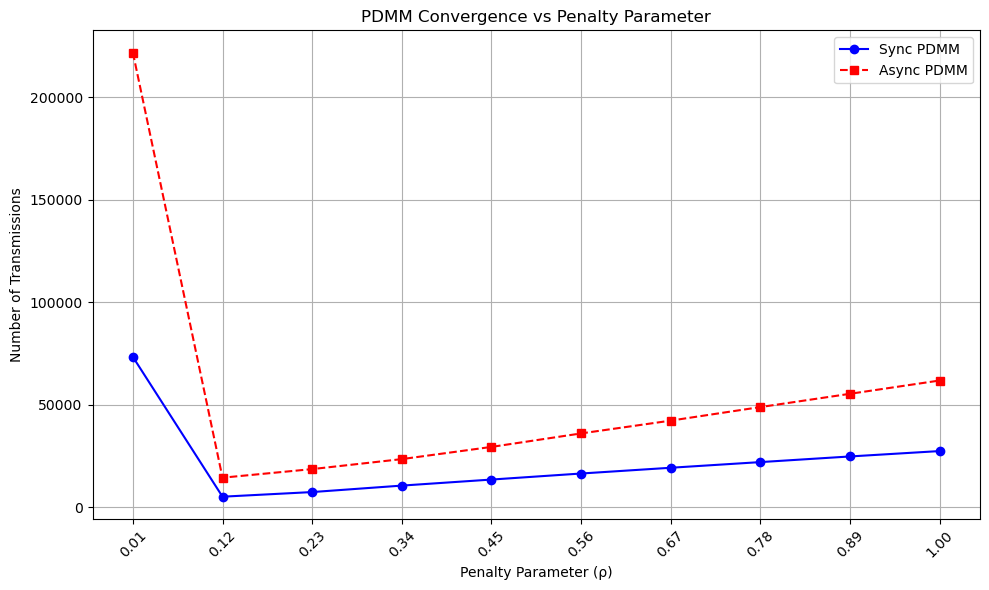

In [54]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM transmissions
rhos = np.linspace(0.01, 1, 10)    # Penalty parameters (c)
tolerance = 1e-12                   # Convergence tolerance

sensor_values = np.random.randn(n) * 10 + 25     # Generate random sensor values

# Synchronous PDMM
transmissions_sync = np.ones(len(rhos)) * max_transmissions
for i, rho in enumerate(rhos):
    errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
    if errors[-1] < tolerance:
        transmissions_sync[i] = n_transmissions

# Asynchronous PDMM
transmissions_async = np.ones(len(rhos)) * max_transmissions
for i, rho in enumerate(rhos):
    errors, values, n_transmissions = pdmm_async(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
    if errors[-1] < tolerance:
        transmissions_async[i] = n_transmissions

# Plot convergence for different rho values
plt.figure(figsize=(10, 6))
plt.plot(rhos, transmissions_sync, marker='o', linestyle='-', color='b', label='Sync PDMM')
plt.plot(rhos, transmissions_async, marker='s', linestyle='--', color='r', label='Async PDMM')
plt.xlabel('Penalty Parameter (ρ)')
plt.ylabel('Number of Transmissions')
plt.title('PDMM Convergence vs Penalty Parameter')
plt.grid(True)
plt.xticks(rhos, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Run Asynchronous PDMM

(ASYNC PDMM) Error below tolerance (9.968255889825486e-13) reached.


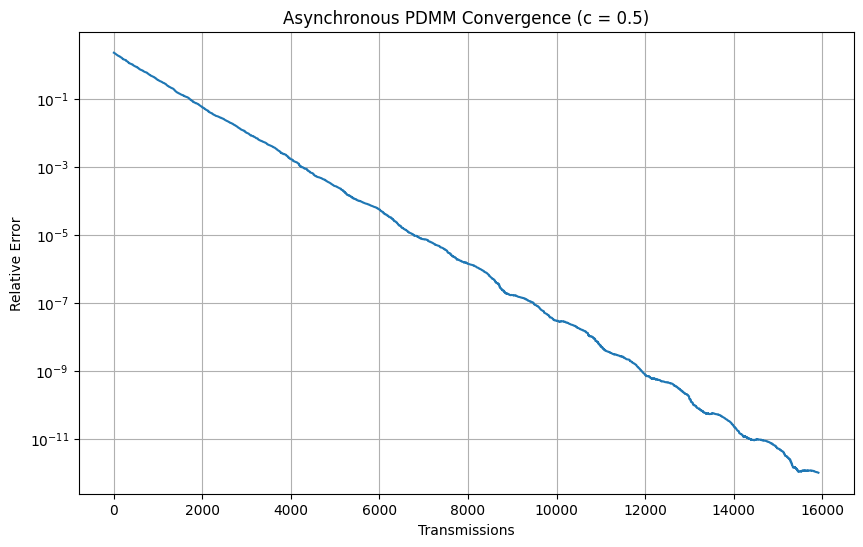

True average: 24.2868
Final average across agents: 24.2868
Min agent value: 24.2868, Max agent value: 24.2868
Final relative error: 9.9683e-13


In [ ]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance

sensor_values = np.random.randn(n) * 10 + 25
errors, values, n_transmissions = pdmm_async(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Asynchronous PDMM Convergence (ρ = {rho})')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

## Median PDMM

Error below tolerance (9.72268441475243e-13) reached.


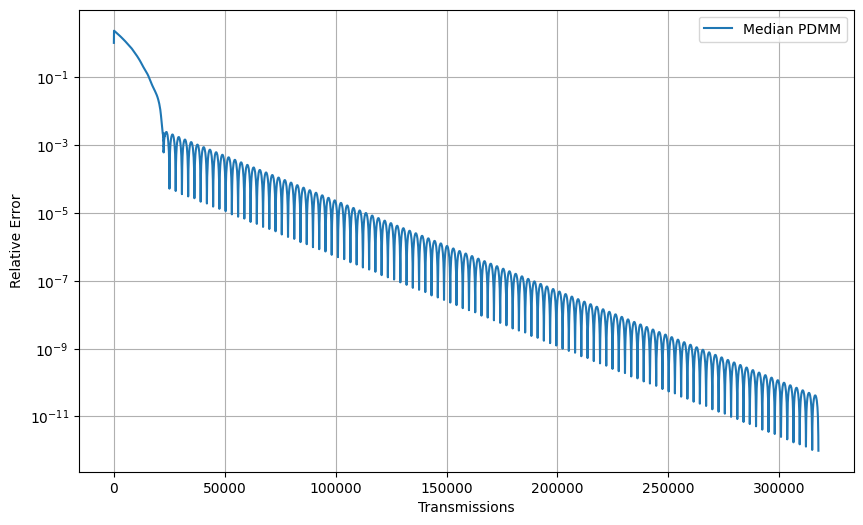

In [9]:
max_transmissions = 1e6             
rho = 0.5                          
tolerance = 1e-12                   
sensor_values = np.random.randn(n) * 10 + 25

errors_async, x = pdmm_median(sensor_values, adjacency_matrix, rho,  max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors_async)), errors_async, label='Median PDMM')
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()

# COMPARISON

(SYNC PDMM) Error below tolerance (9.947583670073958e-13) reached.
(ASYNC PDMM) Error below tolerance (9.985332392704259e-13) reached.
Error below tolerance (9.991239817644354e-13) reached at transmission number 33363.


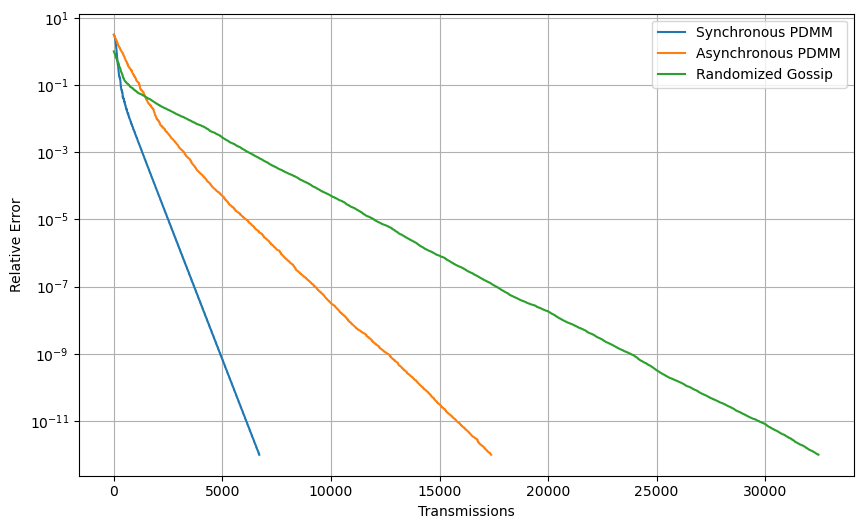

In [52]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.1                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25

errors_sync, values_sync, n_transmissions_sync = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
errors_async, values_async, n_transmissions_async = pdmm_async(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
values, errors_gossip, time = gossip_step(sensor_values, adjacency_matrix, max_ticks=max_transmissions)
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors_sync)), errors_sync, label='Synchronous PDMM')
plt.semilogy(range(len(errors_async)), errors_async, label='Asynchronous PDMM')
plt.semilogy(range(len(errors_gossip)), errors_gossip, label='Randomized Gossip')
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()

### Different $\rho$


(SYNC PDMM) Error below tolerance (9.993685220105533e-13) reached.
(SYNC PDMM) Error below tolerance (9.992697012806697e-13) reached.
(SYNC PDMM) Error below tolerance (9.967501942979327e-13) reached.
(SYNC PDMM) Error below tolerance (9.969734554374585e-13) reached.
(SYNC PDMM) Error below tolerance (9.991643434633527e-13) reached.


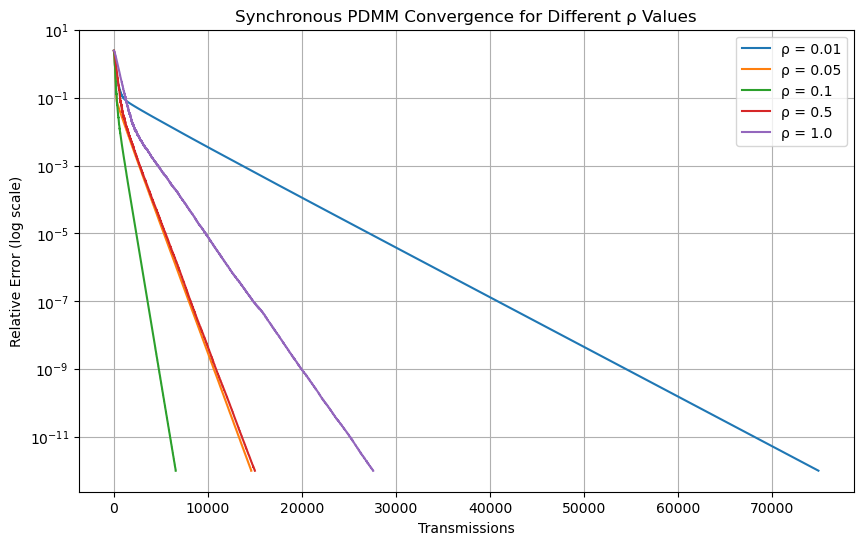

In [50]:

rho_candidates = [0.01, 0.05, 0.1, 0.5, 1.0]
max_transmissions = 1e6
sensor_values = np.random.randn(n) * 10 + 25
results = {}
for rho in rho_candidates:
    errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix,rho,max_transmissions)
    results[rho] = errors
best_rho = min(results.keys(), key=lambda rho: results[rho][-1])

plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Transmissions')
plt.ylabel('Relative Error (log scale)')
plt.title('Synchronous PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


(ASYNC PDMM) Error below tolerance (9.997534630140746e-13) reached.
(ASYNC PDMM) Error below tolerance (9.997590448598977e-13) reached.
(ASYNC PDMM) Error below tolerance (9.999555235369337e-13) reached.
(ASYNC PDMM) Error below tolerance (9.99323668699963e-13) reached.
(ASYNC PDMM) Error below tolerance (9.998090884128395e-13) reached.


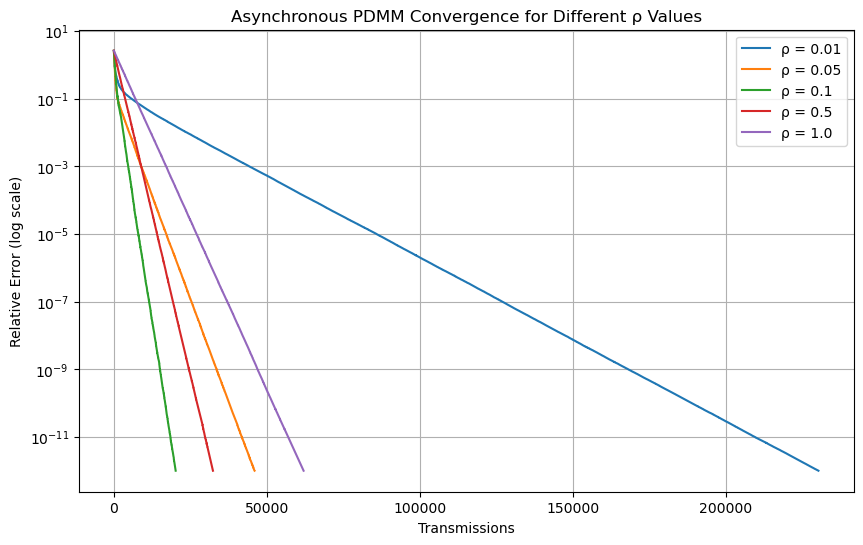

In [51]:
rho_candidates = [0.01, 0.05, 0.1, 0.5, 1.0]
max_transmissions = 1e6
sensor_values = np.random.randn(n) * 10 + 25
results = {}
for rho in rho_candidates:
    errors, values, n_transmissions = pdmm_async(sensor_values.copy(), adjacency_matrix,rho,max_transmissions)
    results[rho] = errors
best_rho = min(results.keys(), key=lambda rho: results[rho][-1])
plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Transmissions')
plt.ylabel('Relative Error (log scale)')
plt.title('Asynchronous PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
rho_candidates = [0.01, 0.05, 0.1, 0.5, 1.0]
sensor_values = np.random.randn(n) * 10 + 25
max_transmissions = 1e6
results = {}
for rho in rho_candidates:
    errors, x = pdmm_median(sensor_values.copy(), adjacency_matrix,rho,max_transmissions)
    results[rho] = errors
best_rho = min(results.keys(), key=lambda rho: results[rho][-1])
plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log scale)')
plt.title('Synchronous Median PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


Error below tolerance (9.99042471874525e-13) reached.
Error below tolerance (9.783161709858149e-13) reached.


### Transmission Loss


(SYNC PDMM) Error below tolerance (9.996104134744449e-13) reached.
(ASYNC PDMM) Error below tolerance (9.974729488024596e-13) reached.
(SYNC PDMM) Error below tolerance (9.994949867718513e-13) reached.
(ASYNC PDMM) Error below tolerance (9.99127839231495e-13) reached.
(SYNC PDMM) Error below tolerance (9.932300697238697e-13) reached.
(ASYNC PDMM) Error below tolerance (9.9888111134428e-13) reached.
(SYNC PDMM) Error below tolerance (9.995850682233699e-13) reached.
(ASYNC PDMM) Error below tolerance (9.99508094105345e-13) reached.
Error below tolerance (9.994514733823148e-13) reached at transmission number 33307.


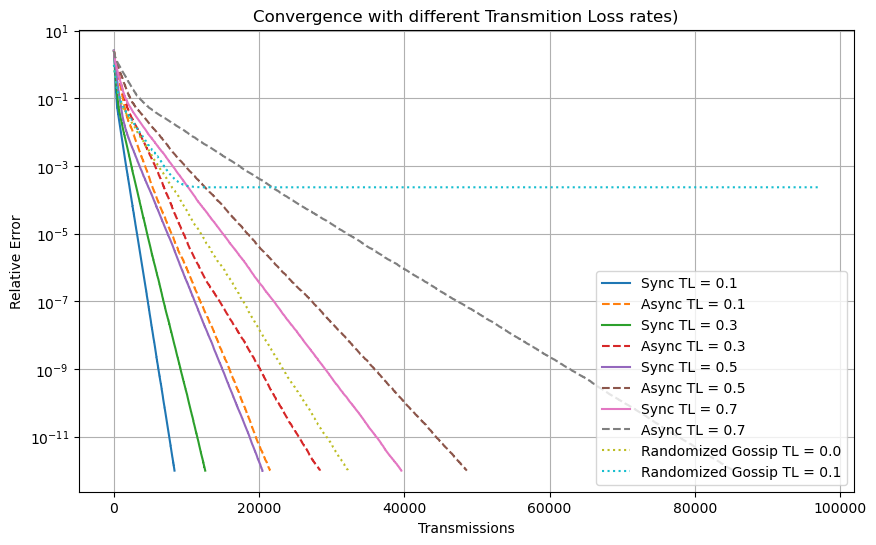

True average: 24.4375
Final average across agents: 24.4375
Min agent value: 24.4375, Max agent value: 24.4375
Final relative error: 9.9959e-13


In [6]:
# PDMM parameters
max_transmissions = 1e5             # Max PDMM iterations
rho = 0.1                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25

transmissions = [0.1,0.3,0.5,0.7]
plt.figure(figsize=(10, 6))
for i in range(len(transmissions)):
    errors, values, n_transmissions = pdmm_sync(sensor_values.copy(), adjacency_matrix, rho, max_transmissions, tolerance,transmissions[i])
    plt.semilogy(range(len(errors)), errors, label=f"Sync TL = {transmissions[i]}")
    errors_async, values_async, n_transmissions_async = pdmm_async(sensor_values.copy(), adjacency_matrix, rho, max_transmissions, tolerance,transmissions[i])
    plt.semilogy(range(len(errors_async)), errors_async, label=f"Async TL = {transmissions[i]}", linestyle='--')

# Plot for 0 transmission loss as well
values_gossip_0, errors_gossip_0, time_0 = gossip_step(sensor_values.copy(), adjacency_matrix, max_ticks=max_transmissions, transmission_loss=0.0)
plt.semilogy(range(len(errors_gossip_0)), errors_gossip_0, label='Randomized Gossip TL = 0.0', linestyle=':')

values_gossip, errors_gossip,  time = gossip_step(sensor_values.copy(), adjacency_matrix, max_ticks=1e5, transmission_loss=0.1)
plt.semilogy(range(len(errors_gossip)), errors_gossip, label='Randomized Gossip TL = 0.1', linestyle=':')

plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Convergence with different Transmition Loss rates)')
plt.grid(True)
plt.legend()
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

## 

## Node drop 


Nodes dropped: 10, Remaining nodes: 61
Graph is connected after drop: True
Nodes dropped: 20, Remaining nodes: 51
Graph is connected after drop: True
Nodes dropped: 30, Remaining nodes: 41
Graph is connected after drop: True
Nodes dropped: 40, Remaining nodes: 31
Graph is connected after drop: True


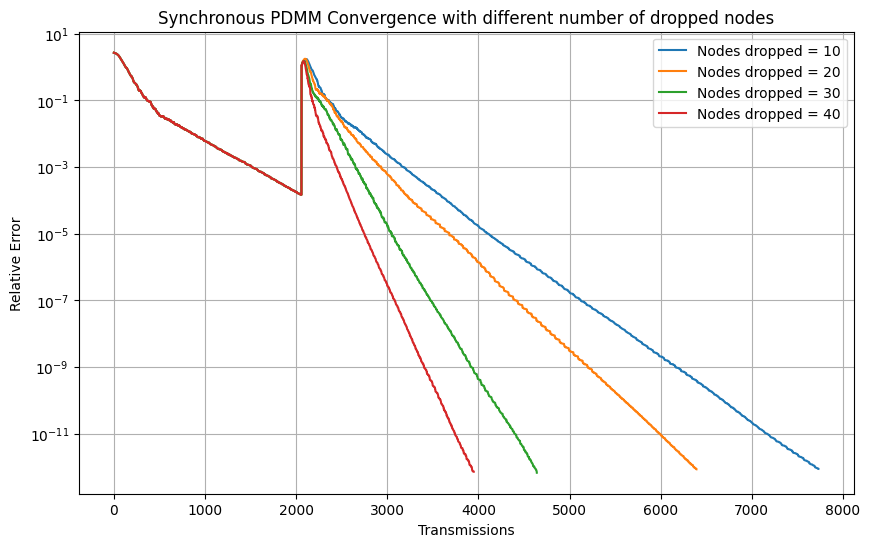

True average: 24.3266
Final average across agents: 24.5824
Min agent value: 24.5824, Max agent value: 24.5824
Final relative error: 7.1995e-13


In [ ]:
# PDMM parameters
max_transmissions = 1e5             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25


nodes = [10,20,30,40]
plt.figure(figsize=(10, 6))
for i in range(len(nodes)):
    errors, values, n_transmissions = pdmm_sync_drop(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance,transmission_loss_rate=0.0, num_drop= nodes[i])
    plt.semilogy(range(len(errors)), errors, label=f"Nodes dropped = {nodes[i]}")

plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Synchronous PDMM Convergence with different number of dropped nodes')
plt.grid(True)
plt.legend()
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")